In [1]:
import predict
import cv2
import numpy
from matplotlib import pyplot as plt

model_name = "../resource/v7-LandCover-retrained-twice"
input_image_filename = "kaka_input.tif"

map_top_left_coords = (0,100)
map_bottom_right_coords = (100,0)
map_grid_cell_size = (10, 10)


2023-06-15 18:16:12.983705: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-15 18:16:13.542707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-15 18:16:13.542817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-15 18:16:13.542823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2023-06-15 18:16:14.587248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/karpase/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-06-15 18:16:14.587304: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Load the NN model

In [2]:
model = predict.load_model(model_name)


## Load the input Map

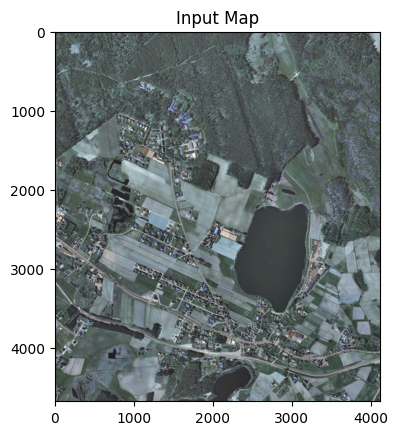

In [3]:
image = cv2.imread(input_image_filename)

plt.imshow(image)
plt.title('Input Map')
plt.show()

## Predict the cover labels


In [4]:
pred, output_image = predict.image_to_pixel_cover(model, image)


Splitting files into  /tmp/tmpwym0glhx
3/3 [==============================] - 4s 1s/step


## Show the cover labels


* black - Background
* red - building
* green - woodland
* blue - water
* white - road


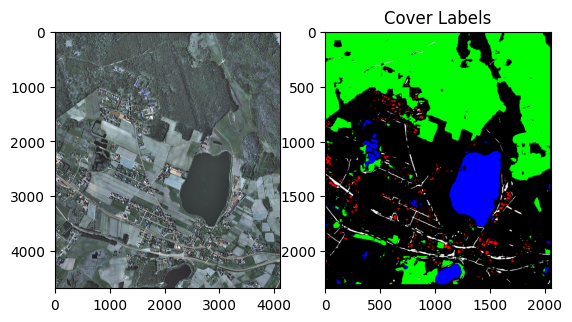

In [5]:
fig, (m1, m2) = plt.subplots(1,2)
plt.title('Cover Labels')
m1.imshow(image)
m2.imshow(output_image)


## Overlay a Grid


(2339, 2056)
delta:  206 234


Text(0.5, 1.0, 'Cover Labels with Grid')

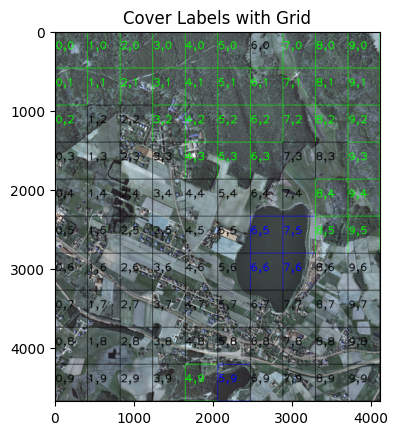

In [27]:
image = cv2.imread(input_image_filename)

minx = min(map_top_left_coords[0], map_bottom_right_coords[0])
maxx = max(map_top_left_coords[0], map_bottom_right_coords[0])

miny = min(map_top_left_coords[1], map_bottom_right_coords[1])
maxy = max(map_top_left_coords[1], map_bottom_right_coords[1])

grid = predict.pixel_labels_to_grid(pred, minx, miny, maxx, maxy, map_grid_cell_size[0], map_grid_cell_size[1])
for i,j in grid:
    x1, y1, x2, y2, histogram = grid[i,j]
    amax = numpy.argmax(histogram)
    color = tuple(map(int, predict.palette[amax]))
    cv2.rectangle(image, (x1*2, y1*2), (x2*2, y2*2), color, 5)
    cv2.putText(image, str(i) + "," + str(j), (x1*2, y1+y2), cv2.FONT_HERSHEY_PLAIN, 10, color, 10, cv2.LINE_AA)


fig, (m1, m2) = plt.subplots(1,2)
plt.title('Cover Labels')
m1.imshow(image)
m2.imshow(output_image)
